In [10]:
%load_ext zipline
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


Entire data start date: 2019-06-03
Entire data end date: 2020-11-27
Backtest months: 18


,Backtest
Annual return,264.4%
Cumulative returns,595.7%
Annual volatility,123.0%
Sharpe ratio,1.62
Calmar ratio,4.16
Stability,0.83
Max drawdown,-63.6%
Omega ratio,1.41
Sortino ratio,2.99
Skew,2.30


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.63,2020-01-30,2020-03-18,2020-06-25,106
1,54.59,2020-07-15,2020-07-21,NaT,NaN
2,37.22,2019-11-19,2019-12-12,2020-01-21,46
3,23.49,2019-08-01,2019-09-12,2019-10-11,52
4,19.66,2020-01-22,2020-01-27,2020-01-30,7


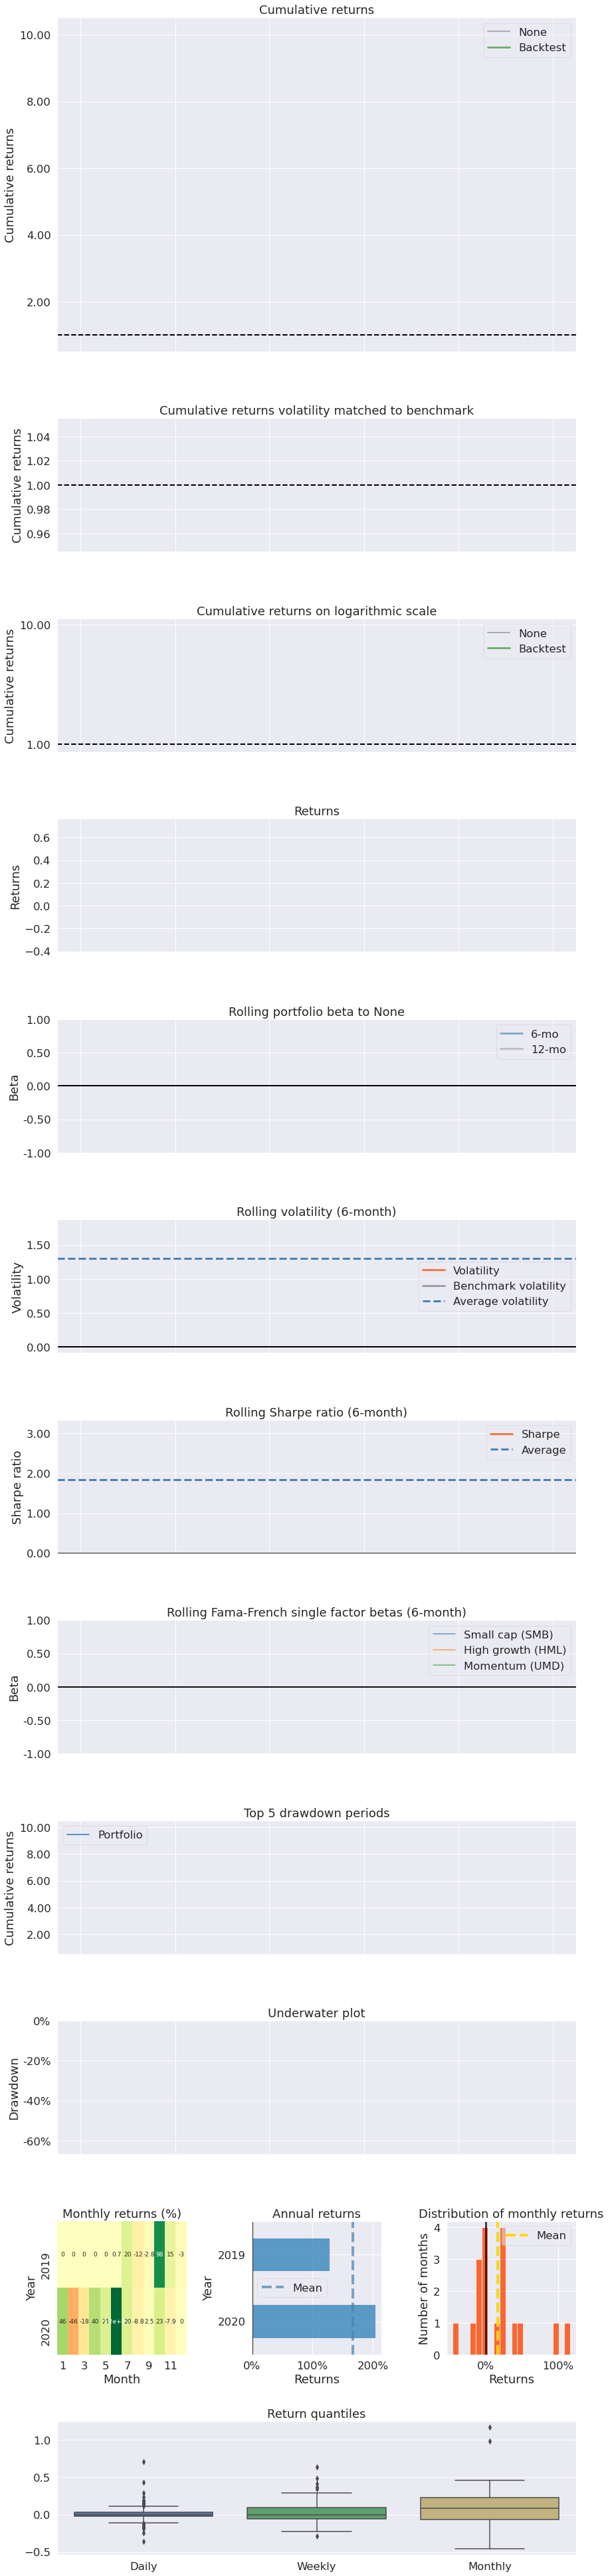

Stress Events,mean,min,max
New Normal,0.79%,-35.74%,70.94%


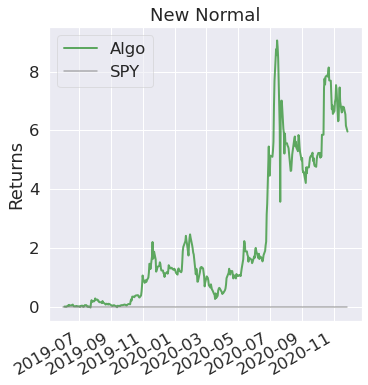

Top 10 long positions of all time,max
NTAR,95.95%


Top 10 short positions of all time,max


Top 10 positions of all time,max
NTAR,95.95%


All positions ever held,max
NTAR,95.95%


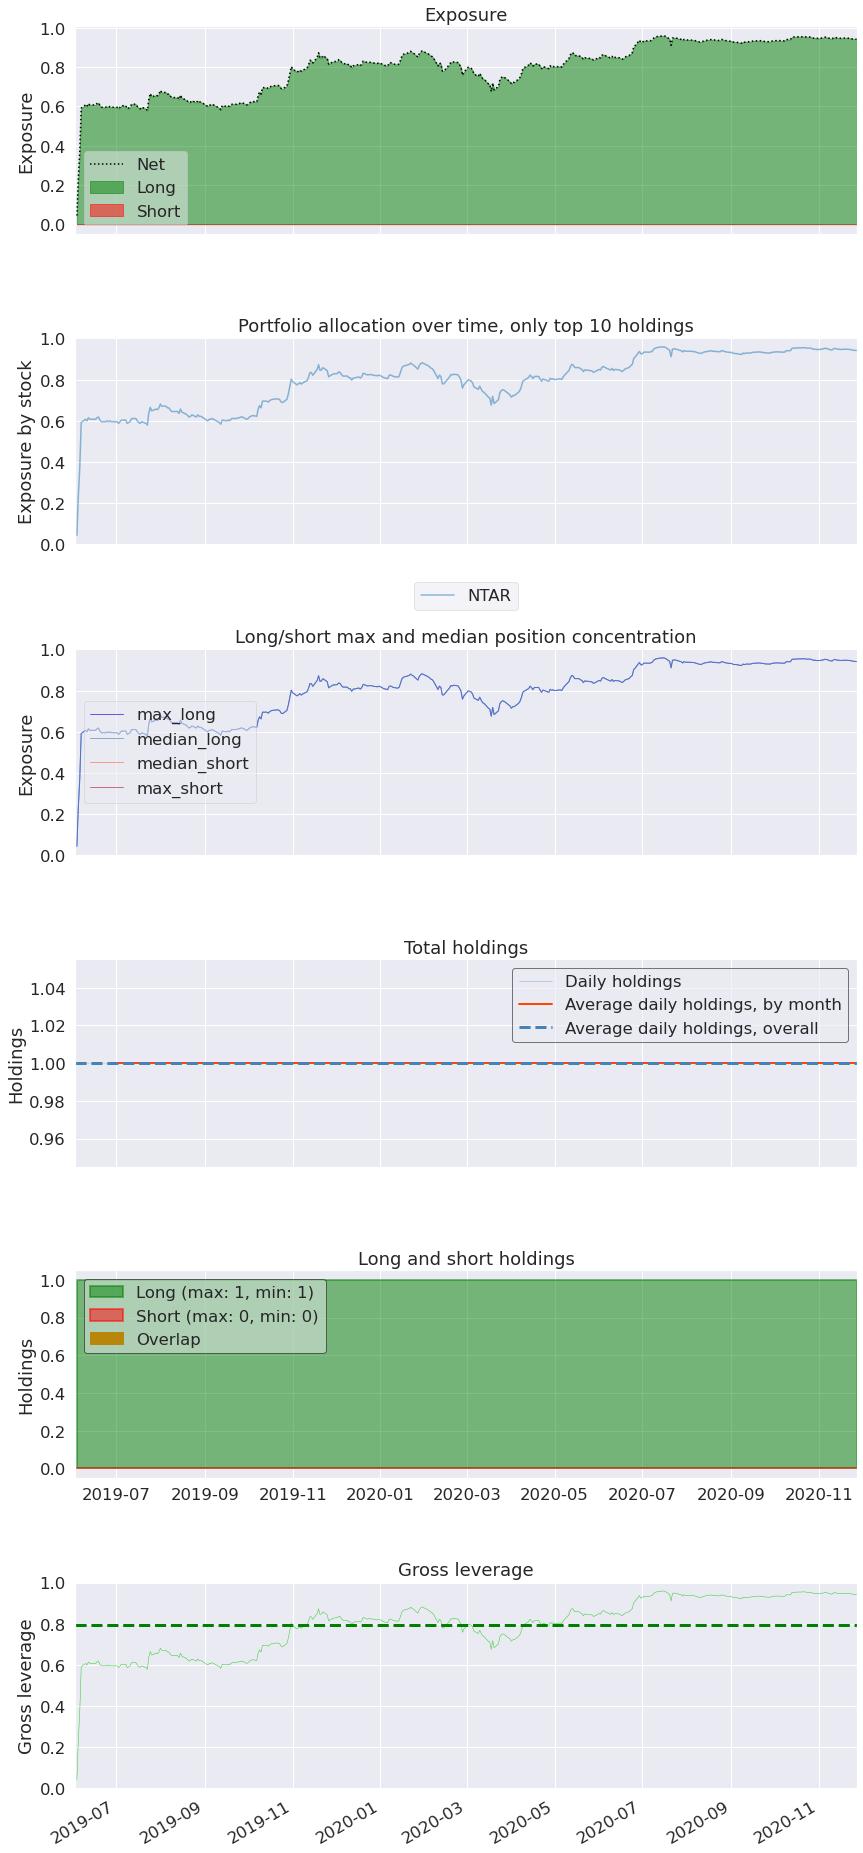

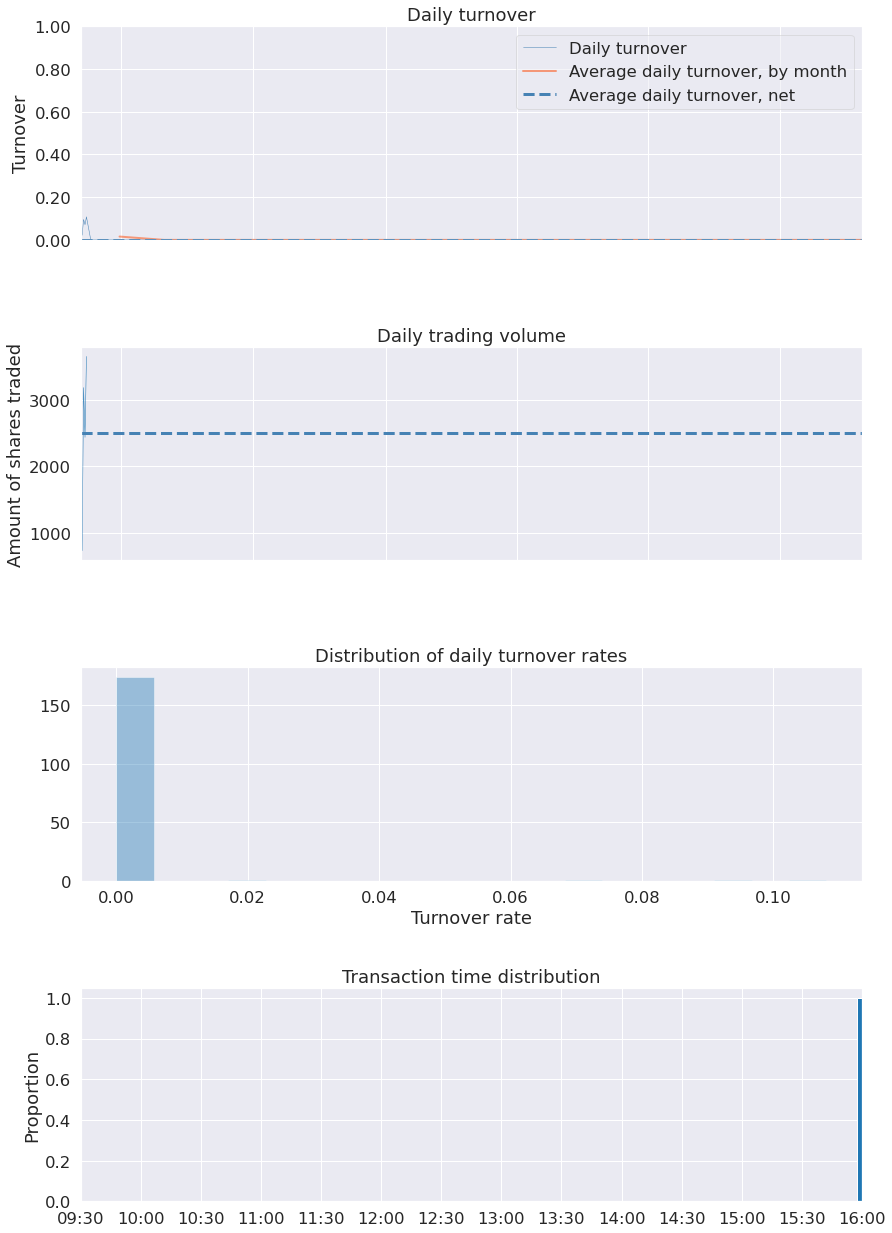

In [11]:
from zipline.api import order, symbol, record, set_benchmark
from zipline import run_algorithm
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf
from datetime import datetime
import pytz
# parameters
selected_stock = 'NTAR'
n_stocks_to_buy = 10000

def initialize(context):
    set_benchmark(symbol('IDK'))
    context.asset = symbol('NTAR')
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True


def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    # pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    start_ref = datetime(2019, 6, 1, 0, 0, 0, 0, pytz.utc)
    end_ref = datetime(2020, 11, 27, 0, 0, 0, 0, pytz.utc)
    benchmark_rets=pd.Series(0,index=pd.date_range(start_ref,end_ref), dtype="float64")
    pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)

# Set start and end date
# start_date = datetime(2019, 9, 3, tzinfo=pytz.UTC)
# end_date = datetime(2020, 11, 27, tzinfo=pytz.UTC)
# pandas compilant timestamp
# need to start early because of 100 day rolling window
start_date = pd.Timestamp('2019-06-01', tz='utc')
end_date = pd.Timestamp('2020-11-27', tz='utc')
# Fire off the backtest
results = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize, 
    analyze=analyze, 
    handle_data=handle_data, 
    capital_base=10000, 
    bundle='bt_testing' 
)

In [12]:
# Checking what columns are in the results dataframe
for column in results:
    print(column)

algo_volatility
algorithm_period_return
alpha
benchmark_period_return
benchmark_volatility
beta
capital_used
ending_cash
ending_exposure
ending_value
excess_return
gross_leverage
long_exposure
long_value
longs_count
max_drawdown
max_leverage
net_leverage
orders
period_close
period_label
period_open
pnl
portfolio_value
positions
price
returns
sharpe
short_exposure
short_value
shorts_count
sortino
starting_cash
starting_exposure
starting_value
trading_days
transactions
treasury_period_return


In [13]:
# Inspecting the first days' exposure
results.gross_leverage.head()

2019-06-03 00:00:00+00:00    0.000000
2019-06-04 00:00:00+00:00    0.043864
2019-06-05 00:00:00+00:00    0.234960
2019-06-06 00:00:00+00:00    0.371455
2019-06-07 00:00:00+00:00    0.591642
Name: gross_leverage, dtype: float64

In [16]:

# Get the backtest data for a particular day
results.loc['2019-11-15']

algo_volatility                                                     0.674939
algorithm_period_return                                              1.27723
alpha                                                                6.77361
benchmark_period_return                                            -0.736842
benchmark_volatility                                                 1.54091
beta                                                               0.0500953
capital_used                                                               0
ending_cash                                                          4072.25
ending_exposure                                                        18700
ending_value                                                           18700
excess_return                                                              0
gross_leverage                                                      0.821175
long_exposure                                                          18700

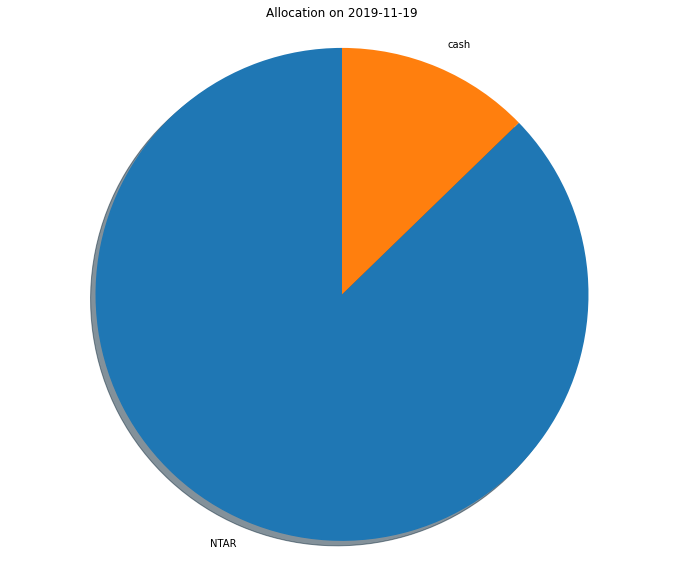

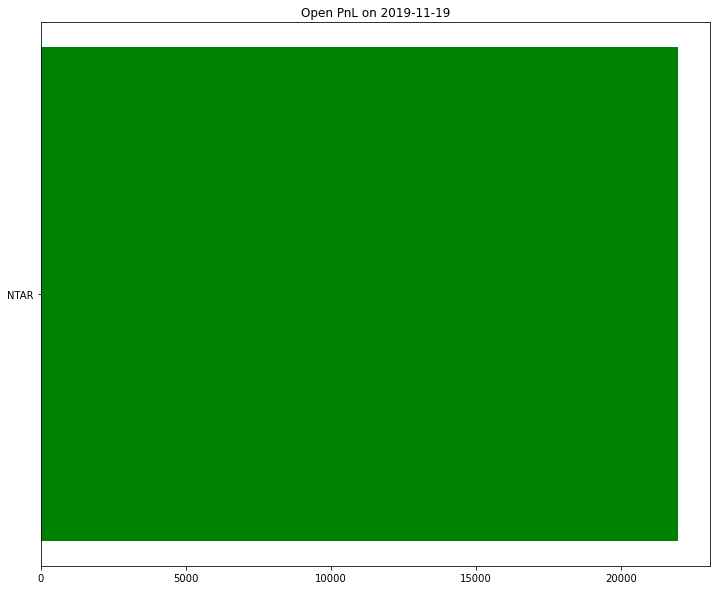

In [20]:

# Let's get a portfolio snapshot
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Select day to view
day = '2019-11-19'

# Get portfolio value and positions for this day
port_value = results.loc[day,'portfolio_value']
day_positions = results.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# Add cash position
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

In [22]:
# df.loc[df['gross_leverage'] > 1.02, 'gross_leverage'] =1.01

findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.


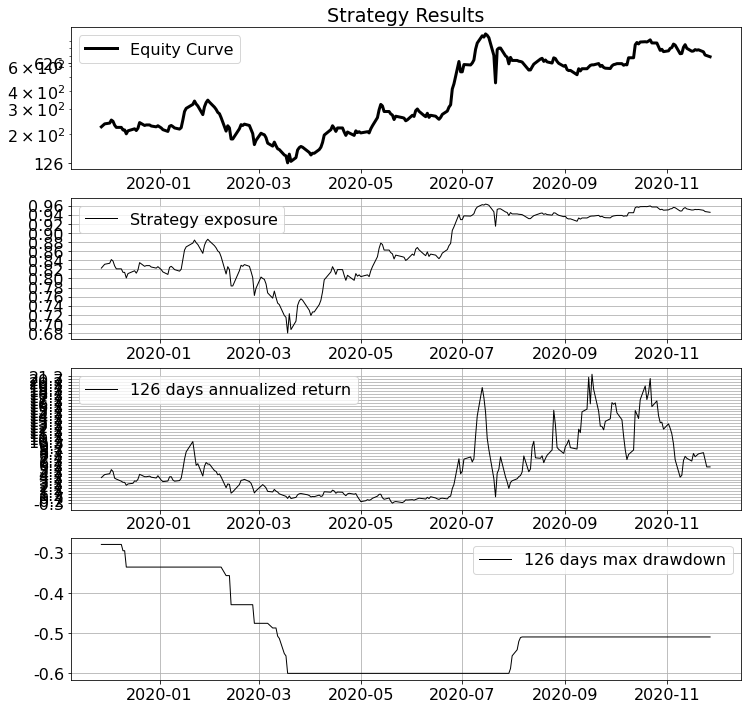

In [24]:

# Custom Time Series Analysis

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, rc, ticker

# Format for book image
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
rc('font', **font)

# Settings
calc_window = 126
year_length = 252

# Copy the columns we need
df = results.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = results.portfolio_value.rolling(calc_window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)